We're using pretrained Mask R-CNN model in https://github.com/matterport/Mask_RCNN/

In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [2]:
DATA_DIR = '/home/jupyter/rsna-pneumonia-data'
ROOT_DIR = '/home/jupyter/'

# Cloning Mask-RCNN model from github.

In [3]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

In [4]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [5]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [23]:
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "./pneumonia20221214T0301/mask_rcnn_pneumonia_0007.h5" #"mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


# Helper functions

In [7]:
# Returns list of dcm fileplaths
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

# Returns image filepath and their corresponding annotations
def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [8]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
     
    NAME = 'pneumonia' # Experiment name 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [9]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        self.add_class('pneumonia', 1, 'Lung Opacity')
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array

        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

# Data processing

In [10]:
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [11]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [13]:
ORIG_SIZE = 1024

In [14]:
# split dataset into training and validation dataset 
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = int(0.05 * len(image_fps_list))
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

25350 1334


In [15]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [16]:
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

# Model Training

In [18]:
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [19]:
import keras
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

Errors seen below don't affect the model training

In [24]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

2022-12-14 05:24:36.696836: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 05:24:36.698499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:24:36.702105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:24:36.704911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Re-starting from epoch 7


In [25]:
LEARNING_RATE = 0.005

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [25]:
%%time
time_callback = TimeHistory()
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=2,
            layers='heads',
            augmentation=None,
            custom_callbacks=[time_callback])
times = time_callback.times
times_list = []
times_list.extend(times)
history = model.keras_model.history.history.copy()


Starting at epoch 0. LR=0.005

Checkpoint Path: /home/jupyter/pneumonia20221214T0301/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Time

2022-12-14 03:02:38.992650: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1153 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -41 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -41 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 1420866355

  1/200 [..............................] - ETA: 1:57:27 - batch: 0.0000e+00 - size: 8.0000 - loss: 33.9151 - rpn_class_loss: 7.1871 - rpn_bbox_loss: 12.7030 - mrcnn_class_loss: 7.5726 - mrcnn_bbox_loss: 5.5645 - mrcnn_mask_loss: 0.8878

2022-12-14 03:03:00.115038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 8.0000 - loss: 15.7088 - rpn_class_loss: 0.8388 - rpn_bbox_loss: 7.9154 - mrcnn_class_loss: 1.1699 - mrcnn_bbox_loss: 5.7779 - mrcnn_mask_loss: 0.0067

2022-12-14 03:05:44.692046: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -896 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -28 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -28 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14208663552

200/200 [==============================] - 322s 1s/step - batch: 99.5000 - size: 8.0000 - loss: 15.7088 - rpn_class_loss: 0.8388 - rpn_bbox_loss: 7.9154 - mrcnn_class_loss: 1.1699 - mrcnn_bbox_loss: 5.7779 - mrcnn_mask_loss: 0.0067 - val_loss: 6.7756 - val_rpn_class_loss: 0.1705 - val_rpn_bbox_loss: 0.4855 - val_mrcnn_class_loss: 2.2871 - val_mrcnn_bbox_loss: 3.8325 - val_mrcnn_mask_loss: 9.8989e-12
Epoch 2/2
200/200 [==============================] - 203s 1s/step - batch: 99.5000 - size: 8.0000 - loss: 2.9075 - rpn_class_loss: 0.2469 - rpn_bbox_loss: 0.7783 - mrcnn_class_loss: 0.7007 - mrcnn_bbox_loss: 1.1816 - mrcnn_mask_loss: 1.1156e-07 - val_loss: 1.8584 - val_rpn_class_loss: 0.1478 - val_rpn_bbox_loss: 0.4839 - val_mrcnn_class_loss: 0.5315 - val_mrcnn_bbox_loss: 0.6951 - val_mrcnn_mask_loss: 1.5584e-08
CPU times: user 3min 18s, sys: 54.8 s, total: 4min 13s
Wall time: 9min 20s


In [27]:
print('Epoch Training time:', times)
print(history)

Epoch Training time: [322.23290634155273, 203.37866067886353]
{'loss': [15.708830389976502, 2.90747008562088], 'rpn_class_loss': [0.8387830257415771, 0.24688032269477844], 'rpn_bbox_loss': [7.915438652038574, 0.7783440947532654], 'mrcnn_class_loss': [1.1699345111846924, 0.7006648778915405], 'mrcnn_bbox_loss': [5.777939319610596, 1.1815803050994873], 'mrcnn_mask_loss': [0.006733516231179237, 1.1155703560916663e-07], 'val_loss': [6.775619230270386, 1.858403091430664], 'val_rpn_class_loss': [0.17046663165092468, 0.14783130586147308], 'val_rpn_bbox_loss': [0.48550620675086975, 0.4839431643486023], 'val_mrcnn_class_loss': [2.287099599838257, 0.5314914584159851], 'val_mrcnn_bbox_loss': [3.832547187805176, 0.6951372027397156], 'val_mrcnn_mask_loss': [9.898942776587205e-12, 1.558430007264633e-08]}


In [29]:
%%time
time_callback = TimeHistory()
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=7,
            layers='all',
            augmentation=augmentation,
           custom_callbacks=[time_callback])

times = time_callback.times
times_list.extend(times)
news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 2. LR=0.005

Checkpoint Path: /home/jupyter/pneumonia20221214T0301/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b    

2022-12-14 03:30:57.896461: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1279 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -41 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -41 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 1420866355

200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 8.0000 - loss: 4.8631 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.4470 - mrcnn_class_loss: 0.4898 - mrcnn_bbox_loss: 0.6061 - mrcnn_mask_loss: 7.5062e-04

2022-12-14 03:42:10.354368: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -896 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -28 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -28 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14208663552

200/200 [==============================] - 831s 4s/step - batch: 99.5000 - size: 8.0000 - loss: 4.8631 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.4470 - mrcnn_class_loss: 0.4898 - mrcnn_bbox_loss: 0.6061 - mrcnn_mask_loss: 7.5062e-04 - val_loss: 4.9465 - val_rpn_class_loss: 0.0835 - val_rpn_bbox_loss: 0.4422 - val_mrcnn_class_loss: 0.4812 - val_mrcnn_bbox_loss: 0.6419 - val_mrcnn_mask_loss: 4.7257e-05
Epoch 4/7
200/200 [==============================] - 809s 4s/step - batch: 99.5000 - size: 8.0000 - loss: 4.7696 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 0.4142 - mrcnn_class_loss: 0.5074 - mrcnn_bbox_loss: 0.5981 - mrcnn_mask_loss: 2.8536e-04 - val_loss: 5.0136 - val_rpn_class_loss: 0.0764 - val_rpn_bbox_loss: 0.5891 - val_mrcnn_class_loss: 0.3843 - val_mrcnn_bbox_loss: 0.6212 - val_mrcnn_mask_loss: 2.5510e-04
Epoch 5/7
200/200 [==============================] - 807s 4s/step - batch: 99.5000 - size: 8.0000 - loss: 4.6808 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.4169 - mrcnn_class_lo

In [30]:
print('Epoch Training time:', times)
print(history)

Epoch Training time: [831.4537842273712, 808.5682008266449, 807.131356716156, 789.0713078975677, 777.927227973938]
{'loss': [15.708830389976502, 2.90747008562088, 4.863141601085663, 4.7696444606781006, 4.680800958871841, 4.600557434558868, 4.582520254850388], 'rpn_class_loss': [0.8387830257415771, 0.24688032269477844, 0.07747365534305573, 0.06990951299667358, 0.0704374611377716, 0.07215016335248947, 0.0680980533361435], 'rpn_bbox_loss': [7.915438652038574, 0.7783440947532654, 0.44695988297462463, 0.41415882110595703, 0.4169255793094635, 0.4192281663417816, 0.4504074454307556], 'mrcnn_class_loss': [1.1699345111846924, 0.7006648778915405, 0.48980581760406494, 0.5074422359466553, 0.4748940169811249, 0.46122172474861145, 0.4314803183078766], 'mrcnn_bbox_loss': [5.777939319610596, 1.1815803050994873, 0.6060572266578674, 0.5980854034423828, 0.5978096723556519, 0.580776572227478, 0.5773918032646179], 'mrcnn_mask_loss': [0.006733516231179237, 1.1155703560916663e-07, 0.0007506246329285204, 0.00

In [27]:
%%time
time_callback = TimeHistory()
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=15,
            layers='all',
            augmentation=augmentation,
            custom_callbacks=[time_callback])

times = time_callback.times
times_list.extend(times)
news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 7. LR=0.001

Checkpoint Path: /home/jupyter/pneumonia20221214T0301/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b    

2022-12-14 05:24:47.870013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:24:47.872100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:24:47.873853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:24:47.875689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:24:47.877489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 8/15


2022-12-14 05:28:14.336516: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1279 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -41 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -41 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\034\000\000\000\034\000\000\000" } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multip

  1/200 [..............................] - ETA: 6:44:18 - batch: 0.0000e+00 - size: 8.0000 - loss: 13.9813 - rpn_class_loss: 3.7236 - rpn_bbox_loss: 10.2175 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

2022-12-14 05:29:15.285453: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-14 05:29:15.285519: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-14 05:29:15.285569: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-12-14 05:29:18.232704: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-14 05:29:18.248629: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-14 05:29:18.492502: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 8902 callback api events and 8901 activity events. 
2022-12-14 05:29:20.100739: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-14 05:29:21.863756: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/jupyter/pneumonia20221214T0301/p

  2/200 [..............................] - ETA: 31:28 - batch: 0.5000 - size: 8.0000 - loss: 13.2119 - rpn_class_loss: 2.0870 - rpn_bbox_loss: 7.5147 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 3.1788 - mrcnn_mask_loss: 0.3706               

2022-12-14 05:29:24.614374: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /home/jupyter/pneumonia20221214T0301/plugins/profile/2022_12_14_05_29_20
Dumped tool data for xplane.pb to /home/jupyter/pneumonia20221214T0301/plugins/profile/2022_12_14_05_29_20/64b358e607cf.xplane.pb
Dumped tool data for overview_page.pb to /home/jupyter/pneumonia20221214T0301/plugins/profile/2022_12_14_05_29_20/64b358e607cf.overview_page.pb
Dumped tool data for input_pipeline.pb to /home/jupyter/pneumonia20221214T0301/plugins/profile/2022_12_14_05_29_20/64b358e607cf.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to /home/jupyter/pneumonia20221214T0301/plugins/profile/2022_12_14_05_29_20/64b358e607cf.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to /home/jupyter/pneumonia20221214T0301/plugins/profile/2022_12_14_05_29_20/64b358e607cf.kernel_stats.pb



200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 8.0000 - loss: 1.9791 - rpn_class_loss: 0.1339 - rpn_bbox_loss: 0.6481 - mrcnn_class_loss: 0.4543 - mrcnn_bbox_loss: 0.7040 - mrcnn_mask_loss: 0.0388

2022-12-14 05:33:34.554653: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -896 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -28 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -28 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\034\000\000\000\034\000\000\000" } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multipr

200/200 [==============================] - 576s 2s/step - batch: 99.5000 - size: 8.0000 - loss: 1.9791 - rpn_class_loss: 0.1339 - rpn_bbox_loss: 0.6481 - mrcnn_class_loss: 0.4543 - mrcnn_bbox_loss: 0.7040 - mrcnn_mask_loss: 0.0388 - val_loss: 1.5444 - val_rpn_class_loss: 0.0915 - val_rpn_bbox_loss: 0.3914 - val_mrcnn_class_loss: 0.4556 - val_mrcnn_bbox_loss: 0.5991 - val_mrcnn_mask_loss: 0.0070
Epoch 9/15
200/200 [==============================] - 255s 1s/step - batch: 99.5000 - size: 8.0000 - loss: 1.5707 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 0.4203 - mrcnn_class_loss: 0.4682 - mrcnn_bbox_loss: 0.5989 - mrcnn_mask_loss: 0.0036 - val_loss: 1.5295 - val_rpn_class_loss: 0.0733 - val_rpn_bbox_loss: 0.3554 - val_mrcnn_class_loss: 0.4701 - val_mrcnn_bbox_loss: 0.6269 - val_mrcnn_mask_loss: 0.0039
Epoch 10/15
200/200 [==============================] - 400s 2s/step - batch: 99.5000 - size: 8.0000 - loss: 1.5394 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.4087 - mrcnn_class_loss: 0.4667 - 

In [29]:
print('Epoch Training time:', times)
print(history)

Epoch Training time: [576.0016617774963, 255.03362822532654, 400.0784981250763, 410.7824516296387, 469.6631762981415, 390.05214738845825, 414.2555112838745, 400.58833837509155]
{'loss': [15.708830389976502, 2.90747008562088, 4.863141601085663, 4.7696444606781006, 4.680800958871841, 4.600557434558868, 4.582520254850388, 1.9791115993261337, 1.570696222782135, 1.5394138926267624, 1.5149298101663589, 1.5296412187814712, 1.4424161767959596, 1.4696868968009948, 1.4896825969219207], 'rpn_class_loss': [0.8387830257415771, 0.24688032269477844, 0.07747365534305573, 0.06990951299667358, 0.0704374611377716, 0.07215016335248947, 0.0680980533361435, 0.13386971, 0.07978119, 0.07236676, 0.07217849, 0.06654694, 0.061523527, 0.0663975, 0.06882568], 'rpn_bbox_loss': [7.915438652038574, 0.7783440947532654, 0.44695988297462463, 0.41415882110595703, 0.4169255793094635, 0.4192281663417816, 0.4504074454307556, 0.6481415, 0.420261, 0.40871534, 0.41932338, 0.42683223, 0.3785715, 0.4235324, 0.38875812], 'mrcnn_c

In [30]:
epochs = range(1,len(next(iter(history.values())))+1)
df = pd.DataFrame(history, index=epochs)
df['epoch_train_time'] = times_list
df.to_csv(ROOT_DIR + 't4-loss-acc-summary.csv')

In [31]:
df.head()

,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,epoch_train_time
1,15.708830,0.838783,7.915439,1.169935,5.777939,6.733516e-03,6.775619,0.170467,0.485506,2.287100,3.832547,9.898943e-12,322.232906
2,2.907470,0.246880,0.778344,0.700665,1.181580,1.115570e-07,1.858403,0.147831,0.483943,0.531491,0.695137,1.558430e-08,203.378661
3,4.863142,0.077474,0.446960,0.489806,0.606057,7.506246e-04,4.946451,0.083455,0.442223,0.481175,0.641917,4.725681e-05,831.453784
4,4.769644,0.069910,0.414159,0.507442,0.598085,2.853565e-04,5.013638,0.076369,0.589142,0.384285,0.621161,2.550951e-04,808.568201
5,4.680801,0.070437,0.416926,0.474894,0.597810,2.003494e-04,4.701506,0.072707,0.382735,0.486422,0.625289,1.538692e-05,807.131357


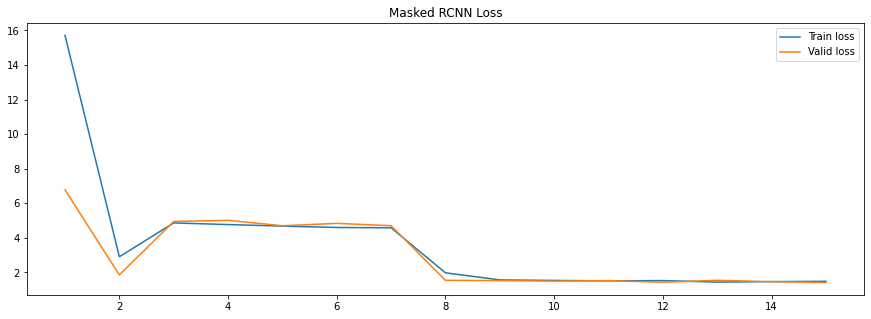

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(111)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.title('Masked RCNN Loss')
plt.legend()
plt.savefig('t4-loss-plot.png')
plt.show()

In [2]:
model_path = '/home/jupyter/pneumonia20221214T0301/mask_rcnn_pneumonia_0015.h5'
print('Found model {}'.format(model_path))

Found model /home/jupyter/pneumonia20221214T0301/mask_rcnn_pneumonia_0015.h5


In [34]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/jupyter/pneumonia20221214T0301/mask_rcnn_pneumonia_0015.h5
Re-starting from epoch 15


# Create the submission file

In [35]:
test_image_fps = get_dicom_fps(test_dicom_dir)

In [36]:
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [37]:
submission_fp = os.path.join(ROOT_DIR, 'submission-0.95.csv')
predict(test_image_fps, filepath=submission_fp, min_conf=0.95)
print(submission_fp)

  0% 0/3000 [00:00<?, ?it/s]2022-12-14 06:43:22.151290: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -50 } dim { size: -208 } dim { size: -209 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -19 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } tensor_content: "\007\000\000\000\007\000\000\000" } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11000" } environment { key: "cudnn" value: "8005" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943

/home/jupyter/submission-0.95.csv
